## UCLA Housing dataset
### Dataset URL: https://www.kaggle.com/apratim87/housingdata/data

In [1]:
import shutil
import math
import multiprocessing
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import data
from tensorflow.python.feature_column import feature_column

print(tf.__version__)

/Users/khalidsalama/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


1.4.0


In [2]:
MODEL_NAME = 'housing-price-model-01'

DATA_FILE = 'data/housingdata.csv'

TRAIN_DATA_FILES_PATTERN = 'data/housing-train-*.csv'
TEST_DATA_FILES_PATTERN = 'data/housing-test-*.csv'

RESUME_TRAINING = False
PROCESS_FEATURES = True
EXTEND_FEATURE_COLUMNS = True
MULTI_THREADING = True

## Define Dataset Metadata

In [3]:
HEADER = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

HEADER_DEFAULTS = [[0.0],[0.0],[0.0],['NA'],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]]

NUMERIC_FEATURE_NAMES = ['CRIM', 'ZN','INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

CATEGORICAL_FEATURE_NAMES_WITH_VOCABULARY = {'CHAS':['0', '1']}
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURE_NAMES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

TARGET_NAME = 'MEDV'

UNUSED_FEATURE_NAMES = list(set(HEADER) - set(FEATURE_NAMES) - {TARGET_NAME})

print("Header: {}".format(HEADER))
print("Numeric Features: {}".format(NUMERIC_FEATURE_NAMES))
print("Categorical Features: {}".format(CATEGORICAL_FEATURE_NAMES))
print("Target: {}".format(TARGET_NAME))
print("Unused Features: {}".format(UNUSED_FEATURE_NAMES))

Header: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
Numeric Features: ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
Categorical Features: ['CHAS']
Target: MEDV
Unused Features: []


## Load and Analyse Dataset

In [4]:
housing_dataset = pd.read_csv(DATA_FILE, header=None, names=HEADER )
housing_dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Visualise and Explore

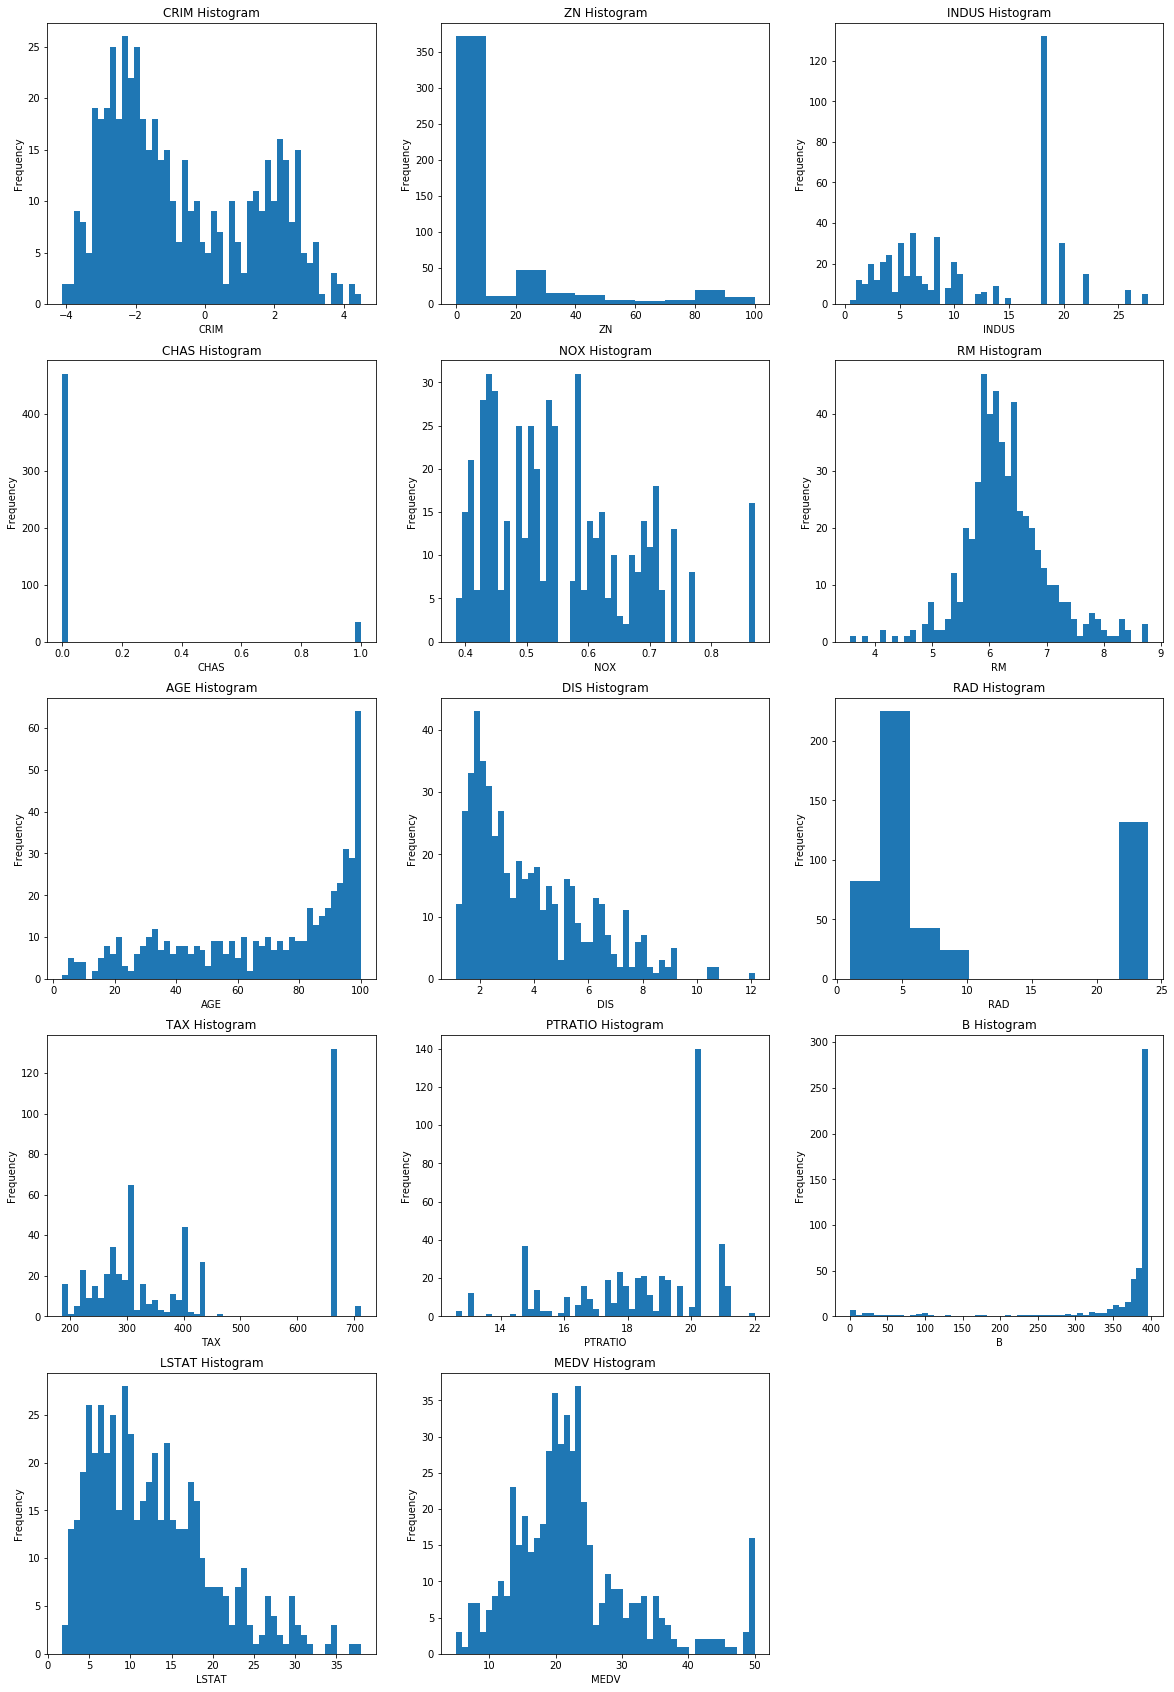

In [21]:
plt.close('all')
plt.figure(figsize=(20, 30))
n_rows = 5
n_cols = 3

for col_index in range(len(housing_dataset.columns)):
    
    bins = 50
    
    feature_name = HEADER[col_index]
    
    plt.subplot(n_rows,n_cols,col_index+1)

    plt.title("{} Histogram".format(feature_name))
    series = housing_dataset[feature_name]
    
    if feature_name in ['CRIM']:
        series = np.log(series+0.01)        
   
    if feature_name in ['ZN','RAD']:
        bins = 10
    
    plt.hist(series, bins=bins)
    plt.xlabel(feature_name)
    plt.ylabel("Frequency")

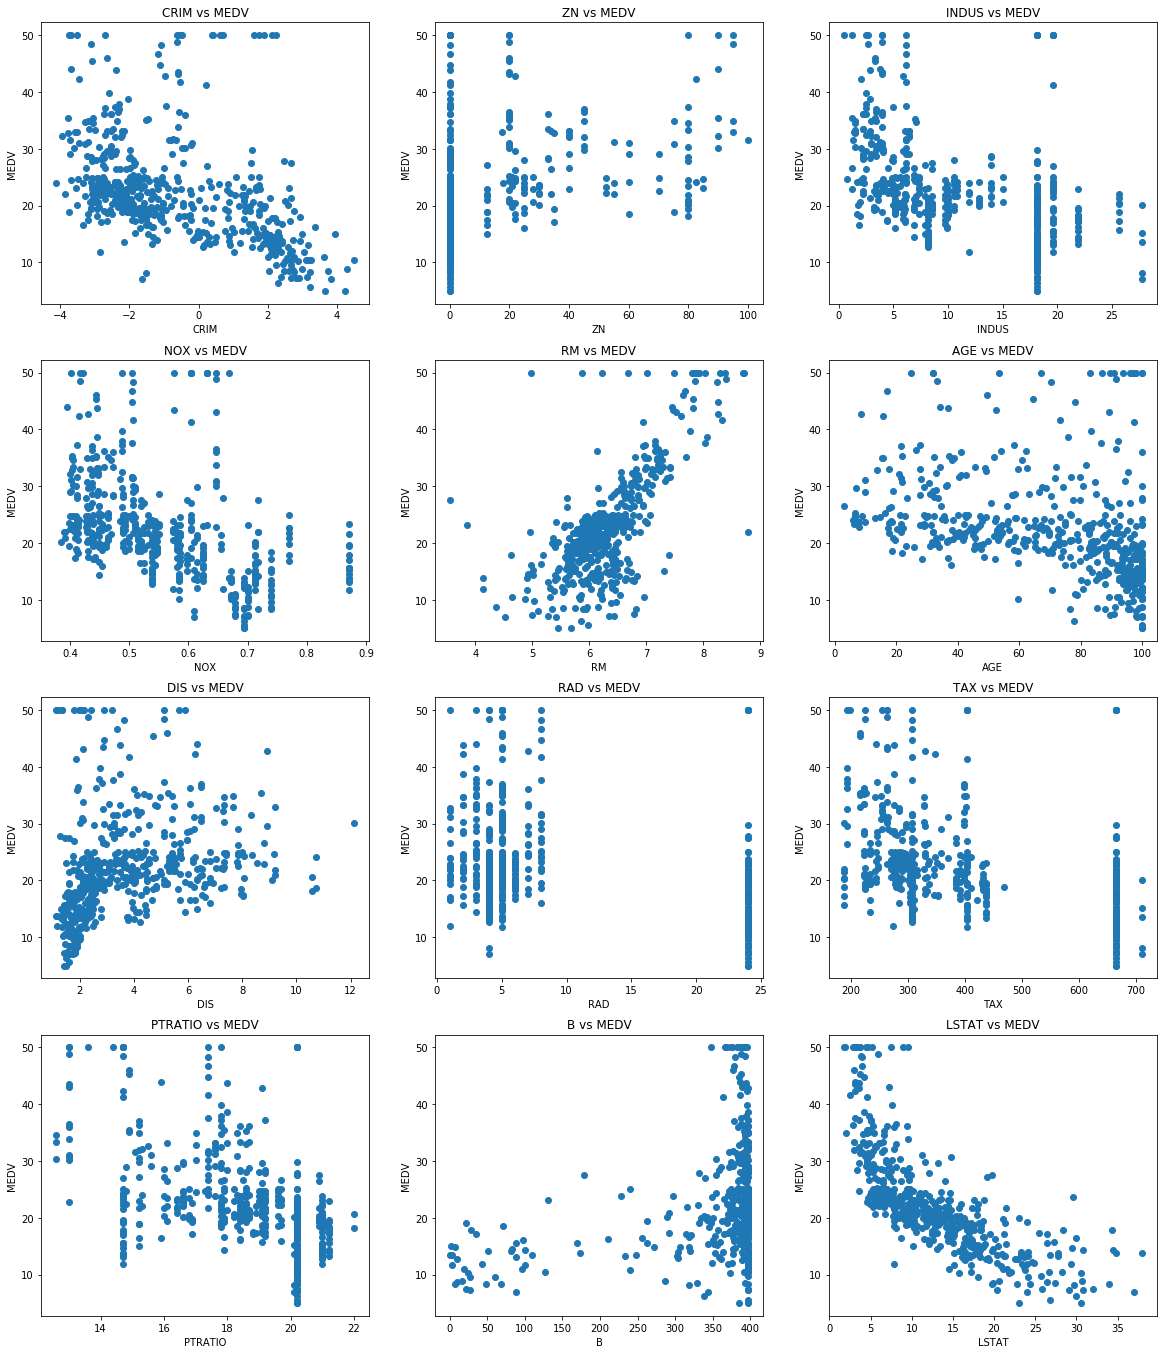

In [6]:
plt.close('all')
plt.figure(figsize=(20, 30))
n_rows = 5
n_cols = 3

for col_index in range(len(FEATURE_NAMES)-1):
    
    feature_name = FEATURE_NAMES[col_index]
    plt.subplot(n_rows, n_cols, col_index+1)
    plt.title("{} vs MEDV".format(feature_name))
    
    if feature_name in NUMERIC_FEATURE_NAMES:
        
        series = housing_dataset[feature_name]
    
        if feature_name == 'CRIM':
            series = np.log(series+0.01)
             
        plt.scatter(series,housing_dataset.MEDV)
        
    else:

        feature_vocab = CATEGORICAL_FEATURE_NAMES_WITH_VOCABULARY[feature_name]
        
        feature_values = []
        for v in feature_vocab:
            feature_values = feature_values + [housing_dataset.MEDV[housing_dataset[feature_name] == v].values]

        plt.boxplot(feature_values)
        
    plt.xlabel(feature_name)
    plt.ylabel("MEDV")

## Prepare Training and Test Sets

In [34]:
DATA_SIZE = len(housing_dataset)

print("Dataset size: {}".format(DATA_SIZE))

train_data = housing_dataset.sample(frac=0.70, random_state = 19830610)
test_data = housing_dataset[~housing_dataset.index.isin(train_data.index)]

TRAIN_DATA_SIZE = len(train_data)
TEST_DATA_SIZE = len(test_data)

print("Train set size: {}".format(TRAIN_DATA_SIZE))
print("Test set size: {}".format(TEST_DATA_SIZE))
print("")

means = train_data[NUMERIC_FEATURE_NAMES].mean(axis=0)
stdvs = train_data[NUMERIC_FEATURE_NAMES].std(axis=0)
maxs = train_data[NUMERIC_FEATURE_NAMES].max(axis=0)
mins = train_data[NUMERIC_FEATURE_NAMES].min(axis=0)
df_params = pd.DataFrame({"mean":means, "stdv":stdvs, "max":maxs, "min":mins})
df_params.head(15)

price_mean = train_data.MEDV.mean()
train_rmse = np.sqrt(np.mean(np.square(train_data.MEDV - price_mean)))
test_rmse = np.sqrt(np.mean(np.square(test_data.MEDV - price_mean)))

print("Mean Price: {}".format(round(price_mean,3)))
print("Train RMSE: {}".format(round(train_rmse,3)))
print("Test RMSE: {}".format(round(test_rmse,3)))

Dataset size: 506
Train set size: 354
Test set size: 152

Mean Price: 22.275
Train RMSE: 8.958
Test RMSE: 9.714


In [8]:
train_data.to_csv(path_or_buf="data/housing-train-01.csv", header=False, index=False)
test_data.to_csv(path_or_buf="data/housing-test-01.csv", header=False, index=False)
df_params.to_csv(path_or_buf="data/housing-params.csv", header=True, index=True)

pd.read_csv("data/housing-train-01.csv", header=None, names=HEADER).head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.12802,0.0,8.56,0,0.5200,6.474,97.1,2.4329,5,384,20.9,395.24,12.27,19.8
1,0.32982,0.0,21.89,0,0.6240,5.822,95.4,2.4699,4,437,21.2,388.69,15.03,18.4
2,0.43571,0.0,10.59,1,0.4890,5.344,100.0,3.8750,4,277,18.6,396.90,23.09,20.0
3,0.03466,35.0,6.06,0,0.4379,6.031,23.3,6.6407,1,304,16.9,362.25,7.83,19.4
4,14.23620,0.0,18.10,0,0.6930,6.343,100.0,1.5741,24,666,20.2,396.90,20.32,7.2


## Define Data Input Functions

### a. parsing and preprocessing logic

In [9]:
def parse_csv_row(csv_row):
    
    columns = tf.decode_csv(csv_row, record_defaults=HEADER_DEFAULTS)
    features = dict(zip(HEADER, columns))
    
    for column in UNUSED_FEATURE_NAMES:
        features.pop(column)
    
    target = features.pop(TARGET_NAME)

    return features, target


def process_features(features):
    
    features['CRIM'] = tf.log(features['CRIM']+0.01)
    
    return features

### b. data pipeline input function

In [10]:
def csv_input_fn(files_name_pattern, mode=tf.estimator.ModeKeys.EVAL, 
                 skip_header_lines=0, 
                 num_epochs=None, 
                 batch_size=200):
    
    shuffle = True if mode == tf.estimator.ModeKeys.TRAIN else False
    
    num_threads = multiprocessing.cpu_count() if MULTI_THREADING else 1
    
    print("")
    print("* data input_fn:")
    print("================")
    print("Input file(s): {}".format(files_name_pattern))
    print("Batch size: {}".format(batch_size))
    print("Epoch Count: {}".format(num_epochs))
    print("Mode: {}".format(mode))
    print("Thread Count: {}".format(num_threads))
    print("Shuffle: {}".format(shuffle))
    print("================")
    print("")
    
    file_names = tf.matching_files(files_name_pattern)

    dataset = data.TextLineDataset(filenames=file_names)
    dataset = dataset.skip(skip_header_lines)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda csv_row: parse_csv_row(csv_row),  num_parallel_calls=num_threads)
    
    if PROCESS_FEATURES:
        dataset = dataset.map(lambda features, target: (process_features(features), target),  num_parallel_calls=num_threads)
    
    dataset = dataset.repeat(num_epochs)
    iterator = dataset.make_one_shot_iterator()
    
    features, target = iterator.get_next()
    return features, target

In [11]:
features, target = csv_input_fn(files_name_pattern="")
print("Features in CSV: {}".format(list(features.keys())))
print("Target in CSV: {}".format(target))


* data input_fn:
Input file(s): 
Batch size: 200
Epoch Count: None
Mode: eval
Thread Count: 4
Shuffle: False

Features in CSV: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
Target in CSV: Tensor("IteratorGetNext:13", shape=(?,), dtype=float32)


## 3. Define Feature Columns
### a. Load scaling params

In [12]:
df_params = pd.read_csv("data/housing-params.csv", header=0, index_col=0)
len(df_params)
df_params['feature_name'] = NUMERIC_FEATURE_NAMES
df_params.head()

,max,mean,min,stdv,feature_name
CRIM,88.9762,3.680534,0.00632,8.706143,CRIM
ZN,100.0000,11.336158,0.00000,23.175461,ZN
INDUS,27.7400,10.912542,0.46000,6.848749,INDUS
NOX,0.8710,0.552093,0.38500,0.114226,NOX
RM,8.7800,6.269175,3.56100,0.720181,RM


### b. Create Feature Columns

In [13]:
def extend_feature_columns(feature_columns, hparams):
    
    
    ZN_bucketized = tf.feature_column.bucketized_column(
        feature_columns['ZN'],
        boundaries = [0,10,100])
        
    RAD_bucketized = tf.feature_column.bucketized_column(
        feature_columns['RAD'],
        boundaries = [0,10,25] )
        
    TAX_bucketized = tf.feature_column.bucketized_column(
        feature_columns['TAX'],
        boundaries = [0,200,300,500,800])
        
    ZN_bucketized_X_ZN_bucketized = tf.feature_column.crossed_column([ZN_bucketized,RAD_bucketized],4)
    ZN_bucketized_X_TAX_bucketized = tf.feature_column.crossed_column([ZN_bucketized,TAX_bucketized],8)
    RAD_bucketized_X_TAX_bucketized = tf.feature_column.crossed_column([RAD_bucketized,TAX_bucketized],8)
    
    
    B_clipped = tf.clip_by_value(features['B'],clip_value_min=0.75, clip_value_max=1) #[0,300,400]
        
    feature_columns['ZN_bucketized'] = ZN_bucketized
    feature_columns['RAD_bucketized'] = RAD_bucketized
    feature_columns['TAX_bucketized'] = TAX_bucketized
    
    feature_columns['ZN_bucketized_X_ZN_bucketized'] = ZN_bucketized_X_ZN_bucketized
    feature_columns['ZN_bucketized_X_TAX_bucketized'] = ZN_bucketized_X_TAX_bucketized
    feature_columns['RAD_bucketized_X_TAX_bucketized'] = RAD_bucketized_X_TAX_bucketized
    
    feature_columns['B'] = B_clipped
    
        
    return feature_columns

def standard_scaler(x, mean, stdv):
    return (x-mean)/(stdv)

def maxmin_scaler(x, max_value, min_value):
    return (x-min_value)/(max_value-min_value)

def get_feature_columns(hparams):
    
    numeric_columns = {}
    
    for feature_name in NUMERIC_FEATURE_NAMES:
        
        feature_max = df_params[df_params.feature_name == feature_name]['max'].values[0]
        feature_min = df_params[df_params.feature_name == feature_name]['min'].values[0]
        normalizer_fn = lambda x: maxmin_scaler(x, feature_max, feature_min)

#         feature_mean = df_params[df_params.feature_name == feature_name]['mean'].values[0]
#         feature_stdv = df_params[df_params.feature_name == feature_name]['stdv'].values[0]
#         normalizer_fn = lambda x: standard_scaler(x, feature_mean, feature_stdv)
        
        numeric_columns[feature_name] = tf.feature_column.numeric_column(feature_name, 
                                                                         normalizer_fn=normalizer_fn
                                                                        )
    CONSTRUCTED_NUMERIC_FEATURES_NAMES = []
    
    if PROCESS_FEATURES:
        for feature_name in CONSTRUCTED_NUMERIC_FEATURES_NAMES:
            numeric_columns[feature_name] = tf.feature_column.numeric_column(feature_name)

    categorical_column_with_vocabulary = \
        {item[0]: tf.feature_column.categorical_column_with_vocabulary_list(item[0], item[1])
         for item in CATEGORICAL_FEATURE_NAMES_WITH_VOCABULARY.items()}
        
    feature_columns = {}

    if numeric_columns is not None:
        feature_columns.update(numeric_columns)

    if categorical_column_with_vocabulary is not None:
        feature_columns.update(categorical_column_with_vocabulary)
    
    if EXTEND_FEATURE_COLUMNS:
        feature_columns = extend_feature_columns(feature_columns, hparams)
        
    return feature_columns

feature_columns = get_feature_columns(tf.contrib.training.HParams(num_buckets=5,embedding_size=3))
print("Feature Columns: {}".format(feature_columns))

Feature Columns: {'CRIM': _NumericColumn(key='CRIM', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_feature_columns.<locals>.<lambda> at 0x11b2fa378>), 'ZN': _NumericColumn(key='ZN', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_feature_columns.<locals>.<lambda> at 0x11b3048c8>), 'INDUS': _NumericColumn(key='INDUS', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_feature_columns.<locals>.<lambda> at 0x119754510>), 'NOX': _NumericColumn(key='NOX', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_feature_columns.<locals>.<lambda> at 0x1197547b8>), 'RM': _NumericColumn(key='RM', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_feature_columns.<locals>.<lambda> at 0x11b3091e0>), 'AGE': _NumericColumn(key='AGE', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_feature_columns.<locals>.<lambda> at 0x11b309158>), 'D

## Define a DNN  Estimator Creation Function

### a. Get wide and deep feature columns

In [14]:
def get_wide_deep_columns():
    
    feature_columns = list(get_feature_columns(hparams).values())
    
    dense_columns = list(
        filter(lambda column: isinstance(column, feature_column._NumericColumn) |
                              isinstance(column, feature_column._EmbeddingColumn),
               feature_columns
        )
    )

    categorical_columns = list(
        filter(lambda column: isinstance(column, feature_column._VocabularyListCategoricalColumn) |
                              isinstance(column, feature_column._BucketizedColumn),
                   feature_columns)
    )
    
    sparse_columns = list(
        filter(lambda column: isinstance(column,feature_column._HashedCategoricalColumn) |
                              isinstance(column, feature_column._CrossedColumn),
               feature_columns)
    )

    indicator_columns = list(
            map(lambda column: tf.feature_column.indicator_column(column),
                categorical_columns)
    )
    
    deep_feature_columns = dense_columns + indicator_columns
    wide_feature_columns = categorical_columns + sparse_columns
    
    return wide_feature_columns, deep_feature_columns
    

In [15]:
def create_DNNComb_estimator(run_config, hparams, print_desc=False):
    
    wide_feature_columns, deep_feature_columns = get_wide_deep_columns()
    
    estimator = tf.estimator.DNNLinearCombinedRegressor(
        
        dnn_feature_columns = deep_feature_columns,
        linear_feature_columns = wide_feature_columns,
        
        dnn_hidden_units= hparams.hidden_units,
        
        dnn_optimizer= tf.train.AdamOptimizer(),
        
        dnn_activation_fn= tf.nn.relu,
        
        config= run_config
    )
    
    
    if print_desc:
        print("")
        print("*Estimator Type:")
        print("================")
        print(type(estimator))
        print("")
        print("*deep columns:")
        print("==============")
        print(deep_feature_columns)
        print("")
        print("wide columns:")
        print("=============")
        print(wide_feature_columns)
        print("")
    
    return estimator

## Run Experiment

### a. Set HParam and RunConfig

In [16]:
TRAIN_SIZE = TRAIN_DATA_SIZE
NUM_EPOCHS = 10000
BATCH_SIZE = 177
EVAL_AFTER_SEC = 30
TOTAL_STEPS = (TRAIN_SIZE/BATCH_SIZE)*NUM_EPOCHS

hparams  = tf.contrib.training.HParams(
    num_epochs = NUM_EPOCHS,
    batch_size = BATCH_SIZE,
    hidden_units=[16, 12, 8],
    max_steps = TOTAL_STEPS
)

model_dir = 'trained_models/{}'.format(MODEL_NAME)

run_config = tf.estimator.RunConfig(
    log_step_count_steps=1000,
    tf_random_seed=19830610,
    model_dir=model_dir
)

print(hparams)
print("Model Directory:", run_config.model_dir)
print("")
print("Dataset Size:", TRAIN_SIZE)
print("Batch Size:", BATCH_SIZE)
print("Steps per Epoch:",TRAIN_SIZE/BATCH_SIZE)
print("Total Steps:", TOTAL_STEPS)
print("That is 1 evaluation step after each",EVAL_AFTER_SEC," training seconds")

[('batch_size', 177), ('hidden_units', [16, 12, 8]), ('max_steps', 20000.0), ('num_epochs', 10000)]
Model Directory: trained_models/housing-price-model-01

Dataset Size: 354
Batch Size: 177
Steps per Epoch: 2.0
Total Steps: 20000.0
That is 1 evaluation step after each 30  training seconds


### c. Define TrainSpec and EvaluSpec

In [17]:
train_spec = tf.estimator.TrainSpec(
    input_fn = lambda: csv_input_fn(
        TRAIN_DATA_FILES_PATTERN,
        mode = tf.estimator.ModeKeys.TRAIN,
        num_epochs=hparams.num_epochs,
        batch_size=hparams.batch_size
    ),
    max_steps=hparams.max_steps,
    hooks=None
)

eval_spec = tf.estimator.EvalSpec(
    input_fn = lambda: csv_input_fn(
        TRAIN_DATA_FILES_PATTERN,
        mode=tf.estimator.ModeKeys.EVAL,
        num_epochs=1,
        batch_size=hparams.batch_size,
            
    ),
    throttle_secs = EVAL_AFTER_SEC,
    steps=None
)

### d. Run Experiment via train_and_evaluate

In [18]:
if not RESUME_TRAINING:
    print("Removing previous artifacts...")
    shutil.rmtree(model_dir, ignore_errors=True)
else:
    print("Resuming training...") 

    
tf.logging.set_verbosity(tf.logging.INFO)

time_start = datetime.utcnow() 
print("Experiment started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................") 

estimator = create_DNNComb_estimator(run_config, hparams, True)

tf.estimator.train_and_evaluate(
    estimator=estimator,
    train_spec=train_spec, 
    eval_spec=eval_spec
)

time_end = datetime.utcnow() 
print(".......................................")
print("Experiment finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Experiment elapsed time: {} seconds".format(time_elapsed.total_seconds()))
    

Removing previous artifacts...
Experiment started at 13:58:03
.......................................
INFO:tensorflow:Using config: {'_model_dir': 'trained_models/housing-price-model-01', '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 1000, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1188d4940>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

*Estimator Type:
<class 'tensorflow.python.estimator.canned.dnn_linear_combined.DNNLinearCombinedRegressor'>

*deep columns:
[_NumericColumn(key='CRIM', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_feature_columns.<locals>.<lambda> at 0x11b309c80>), _NumericColumn(key='ZN', shape=(1,), default_value

INFO:tensorflow:loss = 3089.11, step = 3301 (0.439 sec)
INFO:tensorflow:loss = 2233.51, step = 3401 (0.396 sec)
INFO:tensorflow:loss = 2545.29, step = 3501 (0.388 sec)
INFO:tensorflow:loss = 2456.63, step = 3601 (0.385 sec)
INFO:tensorflow:loss = 2297.76, step = 3701 (0.405 sec)
INFO:tensorflow:loss = 2671.0, step = 3801 (0.403 sec)
INFO:tensorflow:loss = 2316.18, step = 3901 (0.379 sec)
INFO:tensorflow:global_step/sec: 246.635
INFO:tensorflow:loss = 2157.73, step = 4001 (0.397 sec)
INFO:tensorflow:loss = 2312.45, step = 4101 (0.382 sec)
INFO:tensorflow:loss = 2090.7, step = 4201 (0.388 sec)
INFO:tensorflow:loss = 2239.24, step = 4301 (0.428 sec)
INFO:tensorflow:loss = 2333.89, step = 4401 (0.604 sec)
INFO:tensorflow:loss = 2173.8, step = 4501 (0.408 sec)
INFO:tensorflow:loss = 2830.72, step = 4601 (0.381 sec)
INFO:tensorflow:loss = 2250.92, step = 4701 (0.381 sec)
INFO:tensorflow:loss = 2545.32, step = 4801 (0.380 sec)
INFO:tensorflow:loss = 2134.89, step = 4901 (0.382 sec)
INFO:tenso

INFO:tensorflow:loss = 1398.77, step = 13528 (0.405 sec)
INFO:tensorflow:loss = 2405.63, step = 13628 (0.434 sec)
INFO:tensorflow:global_step/sec: 247.016
INFO:tensorflow:loss = 2301.64, step = 13728 (0.418 sec)
INFO:tensorflow:loss = 2032.8, step = 13828 (0.410 sec)
INFO:tensorflow:loss = 1921.48, step = 13928 (0.395 sec)
INFO:tensorflow:loss = 2327.76, step = 14028 (0.397 sec)
INFO:tensorflow:loss = 1757.87, step = 14128 (0.392 sec)
INFO:tensorflow:loss = 1857.65, step = 14228 (0.389 sec)
INFO:tensorflow:loss = 1782.22, step = 14328 (0.391 sec)
INFO:tensorflow:loss = 1816.72, step = 14428 (0.416 sec)
INFO:tensorflow:loss = 2060.65, step = 14528 (0.396 sec)
INFO:tensorflow:loss = 1739.06, step = 14628 (0.393 sec)
INFO:tensorflow:global_step/sec: 251.39
INFO:tensorflow:loss = 1756.3, step = 14728 (0.399 sec)
INFO:tensorflow:loss = 1841.75, step = 14828 (0.405 sec)
INFO:tensorflow:loss = 1661.93, step = 14928 (0.393 sec)
INFO:tensorflow:loss = 1701.88, step = 15028 (0.398 sec)
INFO:tens

## Evaluate the Model

In [19]:
train_input_fn = lambda: csv_input_fn(files_name_pattern= TRAIN_DATA_FILES_PATTERN, 
                                      mode= tf.estimator.ModeKeys.EVAL,
                                      batch_size= TRAIN_DATA_SIZE)


test_input_fn = lambda: csv_input_fn(files_name_pattern= TEST_DATA_FILES_PATTERN, 
                                      mode= tf.estimator.ModeKeys.EVAL,
                                      batch_size= TEST_DATA_SIZE)

estimator = create_DNNComb_estimator(run_config, hparams)

train_results = estimator.evaluate(input_fn=train_input_fn, steps=1)
train_rmse = round(math.sqrt(train_results["average_loss"]),5)
print()
print("############################################################################################")
print("# Train RMSE: {} - {}".format(train_rmse, train_results))
print("############################################################################################")

test_results = estimator.evaluate(input_fn=test_input_fn, steps=1)
test_rmse = round(math.sqrt(test_results["average_loss"]),5)
print()
print("############################################################################################")
print("# Test RMSE: {} - {}".format(test_rmse, test_results))
print("############################################################################################")

INFO:tensorflow:Using config: {'_model_dir': 'trained_models/housing-price-model-01', '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 1000, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1188d4940>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

* data input_fn:
Input file(s): data/housing-train-*.csv
Batch size: 354
Epoch Count: None
Mode: eval
Thread Count: 4
Shuffle: False

INFO:tensorflow:Starting evaluation at 2017-11-25-14:00:30
INFO:tensorflow:Restoring parameters from trained_models/housing-price-model-01/model.ckpt-20000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-11-25-14:00:31
INFO:tensorflow:Saving dict for global step 20000: av

## Prediction

In [20]:
import itertools

predict_input_fn = lambda: csv_input_fn(files_name_pattern= TEST_DATA_FILES_PATTERN, 
                                      mode= tf.estimator.ModeKeys.PREDICT,
                                      batch_size= 5)

predictions = estimator.predict(input_fn=predict_input_fn)
values = list(map(lambda item: item["predictions"][0],list(itertools.islice(predictions, 5))))
print()
print("Predicted Values: {}".format(values))


* data input_fn:
Input file(s): data/housing-test-*.csv
Batch size: 5
Epoch Count: None
Mode: infer
Thread Count: 4
Shuffle: False

INFO:tensorflow:Restoring parameters from trained_models/housing-price-model-01/model.ckpt-20000

Predicted Values: [31.429544, 29.215651, 18.65008, 18.964811, 18.188686]
